# Perform a CTA simulation including a dark matter model

In this notebook, you will generate a CTA observation. The spectral model is described by the annihilation of dark matter particles. The target is only a Toy Halo at a distance of $z=0.02$.

I will use a fits table previously computed using the class ```dmflux_table```. You can check the notebook ```tablemodel``` in this folder. The redshoft $z$ is aready taken into account in the fits table.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gammalib
import ctools
import cscripts

import time

## Modelling the source

For simplicity, I assume the Tor Halo is a point source for CTA. We define some parameters of the target as name, the astrophysical $J$ factor, and the position

In [3]:
srcname = 'HaloA'
jfactor = 1.7e+19
ra      = 80.6
dec     = 23.5

As mentioned at the begining of the notebook, I used a fits based on ```GModelSpectralTable```. The table contains spectra for 200 different values of mass and 200 different energies in the range $30~\text{GeV}$ to $100~\text{GeV}$. You can create your own fits tables using the ```dmflux_table```.

In [4]:
dmspecEW = 'DMModelannaToyHaloEW1.fits'

For this specific model, we compute the normalization of the flux based on the properties of the target and the dark matter candidate. The mass of the candidate is $5~\text{TeV}$ and the $\sigma_{\chi}v$ has $3.0\times10^{-26}~\text{cm}^3~\text{s}^{-1}$. The annihilation channel is to $\tau$ leptons.

In [5]:
mass    = 5.0e+3
channel = 8
sigmav  = 3.0e-26

fluxnorm  = jfactor * sigmav / (8*gammalib.pi*mass**2)
fluxnorm *= 1.0e-3

Now, we can load our model using the ```GModelSpectralTable``` class. As you can note, I set the range $[0.0,10^{40}]$, so we can avoid problems during likelihood fitting (for example).

In [6]:
dmspec = gammalib.GModelSpectralTable()
dmspec.load(dmspecEW)
dmspec['Mass'].value(mass)
dmspec['Channel'].value(channel)
dmspec['Channel'].scale(1)
dmspec['Normalization'].value(fluxnorm)
dmspec['Normalization'].range(0.0, 1.0e+40)

## GModelSky for the source

Now, I define a container for the spatial and spectral part of the model. Remember, the Halo is a point source, and the spectral model is already in ```dmspec``` object.

In [7]:
spatial = gammalib.GModelSpatialPointSource(ra, dec)
dmmodel = gammalib.GModelSky(spatial, dmspec)
dmmodel.name(srcname)

The total model include a spectral correction due to the IRF background.

In [8]:
# spectral correction
spectral = gammalib.GModelSpectralPlaw(1, 0, gammalib.GEnergy(1, 'TeV'))
# background model
bkgmodel = gammalib.GCTAModelIrfBackground(spectral)
bkgmodel.name('Background')
bkgmodel.instruments('CTA')

We combine the two models in a container and save it to the disk.

In [9]:
inmodel = "HaloDMmodel.xml"
models = gammalib.GModels()
models.append(dmmodel)
models.append(bkgmodel)
models.save(inmodel)

In [12]:
emin  = 0.03 # TeV
emax  = 100. # TeV
caldb = 'prod3b-v2'
irf   = 'North_z40_50h'

obssim = ctools.ctobssim()

obssim['inmodel']   = inmodel
obssim['caldb']     = caldb
obssim['irf']       = irf
obssim['seed']      = int(time.time())
obssim['ra']        = ra
obssim['dec']       = dec
obssim['rad']       = 3.0
obssim['tmin']      = '2021-01-01T00:00:00'
obssim['tmax']      = '2021-01-01T00:30:00'
obssim['emin']      = emin
obssim['emax']      = emax
obssim['outevents'] = 'Haloobssim.fits'

obssim.execute()

## Peek at the observation

I saved the observation to a fits file for posterior analysis. For now, let's take a look at the events and generate a skymap:

In [13]:
skymap = ctools.ctskymap(obssim.obs())

skymap['coordsys']    = 'CEL'
skymap['proj']        = 'CAR'
skymap['xref']        = ra
skymap['yref']        = dec
skymap['binsz']       = 0.02
skymap['nxpix']       = 150
skymap['nypix']       = 150
skymap['emin']        = emin
skymap['emax']        = emax
skymap['bkgsubtract'] = 'NONE'

skymap.run()

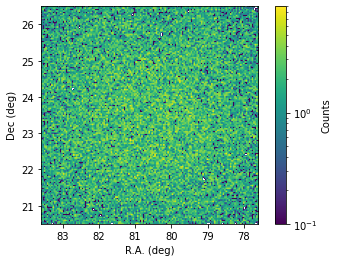

In [14]:
ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
extent=[ra+0.02*150,ra-0.02*150,dec-0.02*150,dec+0.02*150],
# boundaries of the coord grid
norm=LogNorm(vmin=0.1))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

And, well, the events are dominated by the IRF background.